A notebook to create the submission(s).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot, DNase, Regression, Stacked

## Load data

Read the training data with added conservation information.

In [2]:
training = pd.read_csv('data/cagi5_df.csv')
training.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


Read the submission template

In [3]:
submission = pd.read_csv(
    'data/submission-with-cons.tsv',
    sep='\t',
    na_values='*')
submission.sample(6)

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,Direction,P_Direction,Confidence,SE,Comments,phastCon,phyloP,GerpN,GerpRS
2509,1,155271586,C,A,PKLR,NaN,NaN,NaN,NaN,NaN,0.001,0.559,1.30,1.30
3228,1,209989283,G,A,IRF6,NaN,NaN,NaN,NaN,NaN,0.375,0.651,4.33,1.29
9877,11,5248346,T,C,HBB,NaN,NaN,NaN,NaN,NaN,0.817,0.525,4.03,-1.77
10809,19,11199956,C,A,LDLR,NaN,NaN,NaN,NaN,NaN,0.003,-1.541,3.28,-6.51
4603,5,1295204,G,A,TERT-HEK293T,NaN,NaN,NaN,NaN,NaN,0.001,0.298,3.75,2.85
1441,1,155271213,G,A,PKLR,NaN,NaN,NaN,NaN,NaN,0.011,0.457,3.67,1.71


Identify all the submission regions to check they match those in the training data.

In [4]:
sub_regions = submission['Promoter_Enhancer'].unique()
sub_regions.sort()
print(sub_regions)
train_regions = training['regulatory_element'].str.slice(start=8).unique()
train_regions.sort()
print(train_regions)

['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB' 'MYC'
 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']
['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB'
 'MYCrs6983267' 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']


TODO: Make sure that MYC region names match between training and submission data frames.

### Use tuned hyperparameters

These are taken from a kaggle kernel notebook

In [5]:
tuned_params={
    'max_depth': 2, #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': 0.6, #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': 0.5, #[0.5,0.6,0.7,0.8],
    'n_estimators': 1000, #[1000,2000,3000]
    'reg_alpha': 0.03 #[0.01, 0.02, 0.03, 0.04]
}

These are tuned by Bayesian optimisation (in another notebook)

In [6]:
tuned_params = {
    'colsample_bytree': 0.7524052235178577,
    'learning_rate': 0.39783003619093765,
    'max_depth': 7,
    'min_child_weight': 4.0467095559059505,
    'reg_alpha': 0.030682622499703896,
    'reg_lambda': 0.40505823486422077,
    'subsample': 1.0
}

### Choose features

In [7]:
def make_features(test):
    if test:
        ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-3-5-11-test_{}_preds_v1.npy')
    else:
        ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-3-5-11_{}_preds_v1.npy')
    dnase = DNase(test=test)
    conservation = Conservation()
    # subst = SubstitutionOneHot(test=test)
    # enhancer1hot = EnhancerOneHot(test=test)
    # snpcontext2 = SNPContext(context_size=2, test=test)
    # snpcontext4 = SNPContext(context_size=4, test=test)
    # stacked = Stacked('deep-dnase-cons', test=test)
    return MultiFeatures([ds500_dq, dnase, conservation])
train_features = make_features(False)
test_features = make_features(True)

## Fit model

In [8]:
model = Regression(train_features)
X_train = model.get_features(training)
y_train = model.get_response(training)
model.fit(X_train, y_train)

## Make predictions

In [9]:
X_test = test_features.get_features(submission)
predictions = model.predict(X_test, submission.index)
predictions.sample(6)

,PredConfidence,PredValue
5293,0.043814,-0.028780
10045,0.049119,-0.044613
12867,0.088972,-0.037796
4715,0.088426,-0.225350
6704,0.094526,0.006526
7289,0.049306,0.030744


Call which variants are present from the regression predictions

In [10]:
# import models, importlib
# importlib.reload(models)
# from models import call_variants_from_regression
predictions = model.make_submission(predictions)
predictions.sample(6)

,PredConfidence,PredValue,Direction,ValueRank,P_Direction,Confidence,SE
11909,0.079114,-0.096544,0,10009.0,0.347240,0.079114,0.1
13068,0.055041,-0.014782,0,3035.0,0.802111,0.055041,0.1
9772,0.064704,-0.017902,0,3602.0,0.765129,0.064704,0.1
8235,0.039800,-0.025668,0,4834.0,0.684773,0.039800,0.1
7630,0.029150,0.004771,0,1022.0,0.933406,0.029150,0.1
7082,0.099652,-0.035070,0,6099.0,0.602265,0.099652,0.1


Plot the predicted values against the probability that they are correct coloured by called direction.

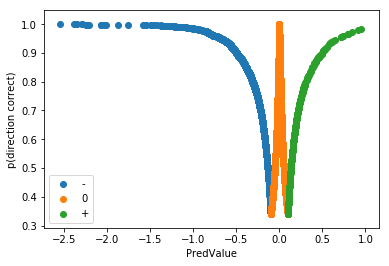

In [11]:
fig, ax = plt.subplots()
neg = -1 == predictions['Direction']
zero = 0 == predictions['Direction']
pos =  1 == predictions['Direction']
ax.scatter(predictions.loc[neg, 'PredValue'], predictions.loc[neg, 'P_Direction'], label='-')
ax.scatter(predictions.loc[zero, 'PredValue'], predictions.loc[zero, 'P_Direction'], label='0')
ax.scatter(predictions.loc[pos, 'PredValue'], predictions.loc[pos, 'P_Direction'], label='+')
ax.legend()
ax.set_xlabel('PredValue')
ax.set_ylabel('p(direction correct)')
None

### Save predictions

In [13]:
import utils, importlib
importlib.reload(utils)
predictions.columns
for col in ['Direction', 'P_Direction', 'Confidence', 'SE']:
    submission[col] = predictions[col]
submission['Comments'] = '*'
utils.write_submission(submission, 'data/submission.tsv')

Writing submission to: data/submission.tsv
